# GeoCLEWs

**Revised code:** [Yalda Saedi](https://github.com/Ysaedi) <br />
**Supervision:** [Taco Niet](https://github.com/tniet) <br />
**Funding** [Mitacs](https://www.mitacs.ca/en) and [Catalyste+](https://www.catalysteplus.org/)

---------------------------

## Summary

GeoCLEWs is a versatile open-source script that offers a wide range of useful features for both developers and users. The script streamlines the detailed land and water processing steps required for Climate Land Energy Water systems (CLEWs) modelling. It is designed to efficiently collect, modify, and process  high-resolution land and water data from Global Agro-ecological Zones (GAEZ v4) database in an automated manner. GeoCLEWs processes agro-climatic potential yield, crop water deficit, crop evapotranspiration, precipitation, and land cover datasets.


This notebook builds upon the [CLEWs GIS Processing notbook](https://github.com/akorkovelos/un-clews-gis-work/blob/main/CLEWs%20GIS%20Processing.ipynb), developed by [Alexandros Korkovelos](https://github.com/akorkovelos), under the supervision of [Abhishek Shivakumar](https://github.com/abhishek0208) & Thomas Alfstad. Please note that the original notebook is currently non-functional due to its incompatibility with the latest version of the GAEZ database. Although the original code served as a valuable starting point, it has undergone significant revisions and improvements:

- Utilizing high-resolution GAEZ v4 datasets to detail land and water systems.
- Implementing customized geographical aggregation and Agglomerative Hierarchical clustering to capture cross-regional interdependencies and streamline computational complexity.
- Automating data collection, preparation, processing, and result generation for diverse geographical regions, reducing manual effort and minimizing human errors in WEF assessment tasks.
- Generating clewsy-compatible outputs.

At the beginning of the script, users can input and tailor the configuration to align with their project's unique requirements. Once the necessary inputs are provided, GeoCLEWs will automatically execute the subsequent steps, including the data collection from FAOSTAT (Food and Agriculture Organization of the United Nation) and retrieving high-resolution raster files from GAEZ v4. Additionally, it implements geographical and spatial clustering to detect cross-regional agro-ecological similarities and generate detailed land and water statistics.

This notebook performs six main analytical processes:

- **Part 1**: Initialization and configuration.
- **Part 2**: FAOSTAT and GAEZ data collection and preparation.
- **Part 3**: Generating land cells.
- **Part 4**: Geospatial attributes extraction to land cells.
- **Part 5**: Spatial clustering using agglomerative hierarchical clustering
- **Part 6**: Calculating key summary statistics generate outputs for further use in CLEWs modelling.

Each part below is accompanied by a more detailed explanation of the involved processing steps.

# Part 1 : Initialization and Configuration

# 1.1. Importing Essential Modules 

To begin, it is necessary to import the required modules/libraries. For more information on the environment setup, please consult the README file. 

In [1]:
# Importing necessary Python modules or libraries

# Numerical
import numpy as np
import pandas as pd
import requests

# Spatial
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
#from geojson import Feature, Point, FeatureCollection
import json
from shapely.geometry import Polygon, Point
# import gdal
from pyproj import CRS
from rasterio.mask import mask
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
import shutil as sh

#Plotting
import ipywidgets
# import plotly.graph_objects as go
# import plotly.express as px
from IPython.display import display, Markdown, HTML
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from sklearn.cluster import KMeans

# System & Other
import time
import os
import datetime
start_time = time.time()


# 1.2. User Configuration  
This is the only part where the user needs to input values. The rest of the process will be automatically run based on the provided inputs. The code is designed with flexibility, allowing users to make changes and take advantage of customized settings at any time during the execution.


In [2]:
# Provide specifications for the project 

Full_name = "Guyana"                   # Specify the full name of the country you wish to analyze (e.g. Kenya).

RCP = "RCP4.5"                        # Choose your preferred RCP (Representative Concentration Pathway) from the available options: RCP2.6, RCP4.5, RCP6.0, RCP8.5.


admin_level = 0                       # 0 for national processing, admin level 0.
                                      # 1 for processing at admin level 1.


#Aggregating regions based on administrative boundaries    
aggregate = False                      # If the admin_level is 1 or higher, you can select specific regions, group them together, and generate Agro-Ecological statistics for these regions as a single aggregated area.                            
                                      # It is crucial that the administrative boundary of the selected regions matches the specified admin_level and input shapefile. 
                                      # Set "False" to disable aggregation and "True" to enable aggregation.
aggregate_region = ["TAI", "TUR"]      # To select regions for aggregation, input the first 3 letters of each region's name, e.g., "TAI" for Taita Taveta county and "TUR" for Turkana county in Kenya, which can be grouped if admin_level=1.
                      
                                      #Aggregated regions are represented by the Grouped Region Cluster (GRC).

                         
scenario = 'jupy'

## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")          # For the analysis, the original WGS84 coordinate system is used. 
crs_proj = CRS("EPSG:24821")          # Please provide proper projection system based on the geographical location of the selected country. 
                                      # In this example EPSG 21037 refers to a specific projection system called the "Kenya Mapping Grid".
                                      # More info: http://epsg.io/ 

## 1.3. Directory Initialization and Structure

For easier replication of the code you may used the following directory structure:

* **~root/Data/input**    (a directory where your input data)
* **~root/global_raster_input**   (directory for GAEZ raster layers with global coverage.  Precipitation and land cover rasters have already downloaded in the global_raster_input while agro-climatic potential yield, crop water deficit, and crop evapotranspiration with global coverage will be downloaded automatically in the following steps based on user input)
* **~root/cropped_raster_input** (a directory for cropped GAEZ global raster data based on administraty boundry of selected country to reduce computational complexity)

Results will be store in two automatically generated directories:
* **~root/Data/output**   (directory for general output)
* **~root/Data/output/summary_stats**   (a directory where the tabular outputs data and graphs are stored)

**Note!** In case you decide to use a different structure please revise the code below.

In [3]:
# Directories

GLOBAL_RASTER_PATH = "./Data/interim_output/global_raster_input"
CROPPED_RASTER_PATH = "./Data/interim_output/cropped_raster_input"
INPUT_DATA_PATH = "./Data/input"
OUTPUT_DATA_PATH = "./Data/output"
INTERIM_DATA_PATH = "./Data/interim_output"
USER_INPUTS_PATH = "./user_input"
SHAPEFILE_PATH = "./user_input/shapefile"

def initialize_directories(scenario):
    do = f"{OUTPUT_DATA_PATH}/{scenario}/"
    paths = ['Data/interim_output', GLOBAL_RASTER_PATH, CROPPED_RASTER_PATH, do, f'{do}summary_stats',
             f"{do}dendrogram_graph", f'{do}elbow_graph', f'{do}spatial_clustering']
    # Initialize output paths for data
    for output_path_raw in paths:
        output_path = f"{output_path_raw}"
        if not os.path.exists(output_path):
            try:
                os.makedirs(output_path)
            except OSError as exc:
                if exc.errno != errno.EEXIST:
                    raise
out_path = OUTPUT_DATA_PATH + "/" + scenario
out_path_clustering = out_path + "/" + "spatial_clustering"
summary_stats_path = out_path + "/" + "summary_stats"
out_path_dendrogram =out_path + "/" + "dendrogram_graph"
out_path_elbow = out_path + "/" + "elbow_graph"
initialize_directories(scenario)

# 3 letter ISO code of the selected country
code = pd.read_csv('Data/Country_code.csv')                            # More info: https://www.nationsonline.org/oneworld/country_code_list.htm
code_name = code[code['Full_name']== Full_name]
country_name = code_name.iloc[0]['country_code']            
            
# supporting vector point name
shp_nm = f"gadm41_{country_name}_{admin_level}.shp"
    
#administrative boundary
admin0_nm = f'gadm41_{country_name}_0.shp'                     # administrative boundaries - national analysis

# Name of final result file
output_nm = "{}_vector_admin{}_land_cells".format(country_name, admin_level)
result_nm = "{}_vector_admin{}_land_cells_with_attributes".format(country_name, admin_level)

# Part 2 : FAOSTAT and GAEZ Data Collection and Preparation

## 2.1. FAOSTAT Collection and Preparation
Finding top 10 crops in terms of harvested area from the latest statistical database provided by Food and Agriculture Organization of the United Nations (FAOSTAT).

### 2.1.1. Retrieve Top 10 Crops

In [4]:
# Read the FAOSTAT file
data = pd.read_csv('Data/FAOSTAT_2020.csv')
filtered_data = data[data['Area'] == Full_name]                

# Sorting based on the harvested area in descending order and get top 10 rows
# Retrieve data according to the user-defined country
top_10_values = filtered_data.nlargest(10, 'Value')
all_crops = top_10_values['Item'].tolist() 

main_crops= all_crops[:5]
other_crops = all_crops[5:]

display(Markdown(' **Top 5 crops considering harvested area are:** {}'.format(main_crops)))
display(Markdown(' **Crops ranked from six to ten in the top 10 FAO dataset are:** {}'.format(other_crops)))

 **Top 5 crops considering harvested area are:** ['Rice', 'Sugar cane', 'Coconuts, in shell', 'Plantains and cooking bananas', 'Maize (corn)']

 **Crops ranked from six to ten in the top 10 FAO dataset are:** ['Ginger, raw', 'Edible roots and tubers with high starch or inulin content, n.e.c., fresh', 'Other tropical fruits, n.e.c.', 'Cassava, fresh', 'Cocoa beans']

### 2.1.2. FAOSTAT Standardizing

In [5]:
# FAO correction: 3 letter naming convention per crop considering CLEWs naming format

Crop_code = pd.read_csv('Data/Crop_code.csv')
crop_name = []  

for item in main_crops:
    matching_rows = Crop_code[Crop_code['Name']==item]
    
    if not matching_rows.empty:
        crop_name.extend(matching_rows['Code'].tolist())  

other_crop_name = []  

for item in other_crops:
    matching_rows = Crop_code[Crop_code['Name']==item]
    
    if not matching_rows.empty:
        other_crop_name.extend(matching_rows['Code'].tolist())  


#Adding "prc" refering to annual precipitation
crop_name = crop_name + ["prc"]

display(Markdown(' **Based on 3-letter naming, the main crop list from the FAOSTAT is :** {}'.format(crop_name)))
display(Markdown(' **Based on 3-letter naming, additional crop list from the FAOSTAT is :** {}'.format(other_crop_name)))



 **Based on 3-letter naming, the main crop list from the FAOSTAT is :** ['SGC', 'CON', 'MZE', 'prc']

 **Based on 3-letter naming, additional crop list from the FAOSTAT is :** ['CAS', 'COC']

## 2.2. GAEZ Data Collection and Preparation

GeoCLEWs collects TIFF data from the Global Agro-Ecological Zones data portal for the following variables: agro-climatic potential yield, crop water deficit, and crop evapotranspiration. Precipitation, and land cover have already downloaded in the directory.

### 2.2.1. GAEZ Data Acquisition

In [6]:
#Import agro-climatic potential yield 
yld_High_input = pd.read_csv('Data/input/GAEZ_yld_High_Input.csv')
yld_Low_input = pd.read_csv('Data/input/GAEZ_yld_Low_Input.csv')

#Import crop water deficit
cwd_High_input = pd.read_csv('Data/input/GAEZ_cwd_High_Input.csv')
cwd_Low_input = pd.read_csv('Data/input/GAEZ_cwd_Low_Input.csv')

#Import crop evapotranspiration 
evt_High_input = pd.read_csv('Data/input/GAEZ_evt_High_Input.csv')
evt_Low_input = pd.read_csv('Data/input/GAEZ_evt_Low_Input.csv')


### 2.2.2. GAEZ Data Preprocessing

In [7]:
#Add a new column for water supply
yld_High_input['New Water Supply'] = yld_High_input['Water Supply'].apply(lambda x: 'Irrigation' if 'irrigation' in x else 'Rain-fed')
yld_Low_input['New Water Supply'] = yld_Low_input['Water Supply'].apply(lambda x: 'Irrigation' if 'irrigation' in x else 'Rain-fed')

cwd_High_input['New Water Supply'] = cwd_High_input['Water Supply'].apply(lambda x: 'Irrigation' if 'irrigation' in x else 'Rain-fed')
cwd_Low_input['New Water Supply'] = cwd_Low_input['Water Supply'].apply(lambda x: 'Irrigation' if 'irrigation' in x else 'Rain-fed')

evt_High_input['New Water Supply'] = evt_High_input['Water Supply'].apply(lambda x: 'Irrigation' if 'irrigation' in x else 'Rain-fed')
evt_Low_input['New Water Supply'] = evt_Low_input['Water Supply'].apply(lambda x: 'Irrigation' if 'irrigation' in x else 'Rain-fed')

### 2.2.3. GAEZ Data Standardizing

In [8]:
        
def GAEZ_naming (dataset, filename):
    
    dataset['New Crop'] = dataset['Crop'].apply(lambda x: Crop_code.loc[Crop_code['GAEZ_name'] == x, 'Code'].values[0] if x in Crop_code['GAEZ_name'].values else 'Nan')
    dataset.to_csv(filename, index=False)
    
GAEZ_naming (yld_High_input, 'Data/interim_output/New_yld_High_input.csv')
GAEZ_naming (yld_Low_input, 'Data/interim_output/New_yld_Low_input.csv')
GAEZ_naming (cwd_High_input, 'Data/interim_output/New_cwd_High_input.csv')
GAEZ_naming (cwd_Low_input, 'Data/interim_output/New_cwd_Low_input.csv')
GAEZ_naming (evt_High_input, 'Data/interim_output/New_evt_High_input.csv')
GAEZ_naming (evt_Low_input, 'Data/interim_output/New_evt_Low_input.csv')

### 2.2.4. GAEZ Data Filtering according to User Configuration

In [9]:
#filtering in accordance with user-defined RCP 
Filtered_yld_High_input = yld_High_input[yld_High_input['RCP'] == RCP]
Filtered_cwd_High_input = cwd_High_input[cwd_High_input['RCP'] == RCP]
Filtered_evt_High_input = evt_High_input[evt_High_input['RCP'] == RCP]

#filtering based on with user-defined crops
def GAEZ_List(dataframe, crop_list, column):
    List = pd.DataFrame()
    for crop in crop_list:
        if dataframe[column].str.contains(crop).any():
            List = pd.concat([List, dataframe[dataframe[column].str.contains(crop)]])
    return List



Main_yld_High=GAEZ_List(Filtered_yld_High_input, crop_name, "New Crop")
Other_yld_High=GAEZ_List(Filtered_yld_High_input, other_crop_name, "New Crop")
Main_yld_Low=GAEZ_List(yld_Low_input, crop_name, "New Crop")
Other_yld_Low=GAEZ_List(yld_Low_input, other_crop_name, "New Crop")

Main_cwd_High=GAEZ_List(Filtered_cwd_High_input, crop_name, "New Crop")
Other_cwd_High=GAEZ_List(Filtered_cwd_High_input, other_crop_name, "New Crop")
Main_cwd_Low=GAEZ_List(cwd_Low_input, crop_name, "New Crop")
Other_cwd_Low=GAEZ_List(cwd_Low_input, other_crop_name, "New Crop")

Main_evt_High=GAEZ_List(Filtered_evt_High_input, crop_name, "New Crop")
Other_evt_High=GAEZ_List(Filtered_evt_High_input, other_crop_name, "New Crop")
Main_evt_Low=GAEZ_List(evt_Low_input, crop_name, "New Crop")
Other_evt_Low=GAEZ_List(evt_Low_input, other_crop_name, "New Crop")


### 2.2.5. Downloading and Storing GAEZ Raster Files in a clewsy-Compatible Format

In [10]:
def download_URL(dataframe, column, folder_name):
    for index, row in dataframe.iterrows():
        url = str(row[column])
        filename = str(row['New Crop']) + ' ' + ('cwd' if str(row['Name'].split('_')[-1]) == "wde" else 'evt' if str(row['Name'].split('_')[-1]) == "eta" else str(row['Name'].split('_')[-1])) + ' ' + str(row['New Water Supply']) + ' ' + str(row['Input Level'])
        file_path = os.path.join(folder_name, filename + '.tif')

        response = requests.get(url)

        with open(file_path, 'wb') as file:
            file.write(response.content)

        print(f"Downloaded: {filename}")

in_path_raster = GLOBAL_RASTER_PATH
download_URL(Main_yld_High, 'Download URL', in_path_raster)
download_URL(Other_yld_High, 'Download URL', in_path_raster)
download_URL(Main_yld_Low, 'Download URL', in_path_raster)
download_URL(Other_yld_Low, 'Download URL', in_path_raster)

download_URL(Main_cwd_High, 'Download URL', in_path_raster)
download_URL(Other_cwd_High, 'Download URL', in_path_raster)
download_URL(Main_cwd_Low, 'Download URL', in_path_raster)
download_URL(Other_cwd_Low, 'Download URL', in_path_raster)

download_URL(Main_evt_High, 'Download URL', in_path_raster)
download_URL(Other_evt_High, 'Download URL', in_path_raster)
download_URL(Main_evt_Low, 'Download URL', in_path_raster)
download_URL(Other_evt_Low, 'Download URL', in_path_raster)
sh.copyfile(f'{INPUT_DATA_PATH}/precipitation prc.tif', f'{GLOBAL_RASTER_PATH}/precipitation prc.tif')
sh.copyfile(f'{INPUT_DATA_PATH}/LCType_ncb.tif', f'{GLOBAL_RASTER_PATH}/LCType_ncb.tif')

Downloaded: SGC yld Irrigation High
Downloaded: SGC yld Rain-fed High
Downloaded: CON yld Irrigation High
Downloaded: CON yld Rain-fed High
Downloaded: MZE yld Irrigation High
Downloaded: MZE yld Rain-fed High
Downloaded: CAS yld Irrigation High
Downloaded: CAS yld Rain-fed High
Downloaded: COC yld Irrigation High
Downloaded: COC yld Rain-fed High
Downloaded: SGC yld Irrigation Low
Downloaded: SGC yld Rain-fed Low
Downloaded: CON yld Irrigation Low
Downloaded: CON yld Rain-fed Low
Downloaded: MZE yld Irrigation Low
Downloaded: MZE yld Rain-fed Low
Downloaded: CAS yld Irrigation Low
Downloaded: CAS yld Rain-fed Low
Downloaded: COC yld Irrigation Low
Downloaded: COC yld Rain-fed Low
Downloaded: SGC cwd Irrigation High
Downloaded: SGC cwd Rain-fed High
Downloaded: CON cwd Irrigation High
Downloaded: CON cwd Rain-fed High
Downloaded: MZE cwd Irrigation High
Downloaded: MZE cwd Rain-fed High
Downloaded: CAS cwd Irrigation High
Downloaded: CAS cwd Rain-fed High
Downloaded: COC cwd Irrigation

# Part 3: Generating Land Cells

## 3.1. Generating Georeferenced Point Grid from Shapefile
Considering the resolution of GAEZ raster files, it is recommended to set spacing to 0.09 decimal degrees resulting in a detailed land and water analysis.

In [11]:
#create a GeoDataFrame from the attributes and geometry of the shapefile
in_path = SHAPEFILE_PATH
shapefile = gpd.read_file(in_path + "/" + shp_nm)
shapefile = shapefile.to_crs(crs_WGS84)

In [12]:
#Creating point grid

out_path = f'{OUTPUT_DATA_PATH}/{scenario}'
spacing = 0.09
xmin, ymin, xmax, ymax = shapefile.total_bounds

xcoords = [i for i in np.arange(xmin, xmax, spacing)]
ycoords = [i for i in np.arange(ymin, ymax, spacing)]

pointcoords = np.array(np.meshgrid(xcoords, ycoords)).T.reshape(-1, 2) 
points = gpd.points_from_xy(x=pointcoords[:,0], y=pointcoords[:,1])
grid = gpd.GeoSeries(points, crs=shapefile.crs)
grid.name = 'geometry'


#only points inside administrative boundary:
gridinside = gpd.sjoin(gpd.GeoDataFrame(grid), shapefile[['geometry']], how="inner")

#Plot georeferenced point grid
fig, ax = plt.subplots(figsize=(20, 20))
shapefile.plot(ax=ax, alpha=0.7, color="pink", edgecolor='red', linewidth=3)
grid.plot(ax=ax, markersize=30, color="blue")
gridinside.plot(ax=ax, markersize=15, color="yellow")
file_path = os.path.join(out_path, "{}_PointGrid.png".format(country_name))
plt.savefig(file_path)

## 3.2. Converting Points to Polygons

A regular grid point is created across the entire area of interest in the previous step. Georeferenced points have unique latitude and longitude. In this step,  square buffer-based polygons are created around each point. This allows further flexibility in the extraction of raster values using stats. The buffered polygon shall split "equally" the area between neighbor points; therefore, the buffer used shall be the half of the distance between two neighbor points. This, in turn depends on the location of the AoI on earth and the projection system used. 

### 3.2.1. Spatial Join
Assigning the same administrative region as defined in the GeoDataFrame to the 'cluster' column.

In [13]:
# Calculate the centroids 
clustered_gdf = gridinside
clustered_gdf = clustered_gdf.to_crs(crs_WGS84)

In [14]:
# Rename the columns to cluster
clustered_gdf.rename(columns={'index_right': 'cluster'}, inplace=True)

# Convert cluster column to string
clustered_gdf.cluster = clustered_gdf.cluster.astype(str).replace('0', 'NaN')

In [16]:
# Reset the index of the left dataframe
clustered_gdf = clustered_gdf.reset_index(drop=True)
admin_name = "NAME_" + str(admin_level)

if admin_level == 0:
    # Perform the spatial join
    clustered_gdf = gpd.sjoin(clustered_gdf, shapefile[["geometry", "GID_0"]], predicate='within').drop(['cluster'], axis=1)
    
    # Rename the 'GID_0' column to 'cluster'
    clustered_gdf.rename(columns={'GID_0': 'cluster'}, inplace=True)
else:
    # Perform the spatial join
    clustered_gdf = gpd.sjoin(clustered_gdf, shapefile[["geometry", admin_name]], predicate='within').drop(['cluster'], axis=1)
    
    # Rename the 'NAME_1' column to 'cluster'
    clustered_gdf.rename(columns={admin_name: 'cluster'}, inplace=True)

# Print the first 5 rows of the joined GeoDataFrame
clustered_gdf.head(3)


,geometry,index_right,cluster
0,POINT (-61.29692 5.85677),0,GUY
1,POINT (-61.29692 5.94677),0,GUY
2,POINT (-61.29692 6.03677),0,GUY


In [17]:
# create a new column based on first 3 letters of the 'cluster' column
clustered_gdf['new_cluster'] = clustered_gdf['cluster'].apply(lambda x:  x[:3]).str.upper()
clustered_gdf = clustered_gdf.rename(columns={'cluster': 'old_cluster'})
clustered_gdf = clustered_gdf.rename(columns={'new_cluster': 'cluster'})
clustered_gdf = clustered_gdf.drop(columns=['old_cluster'])
clustered_gdf.head(3)


,geometry,index_right,cluster
0,POINT (-61.29692 5.85677),0,GUY
1,POINT (-61.29692 5.94677),0,GUY
2,POINT (-61.29692 6.03677),0,GUY


### 3.2.2. Region Aggregation


In [18]:
#Aggregating subnational regions based on user-defined aggregation list. The aggregated land cells of regions are represented by the Grouped Region Cluster (GRC).
if aggregate == True:
    clustered_gdf['cluster'] = clustered_gdf['cluster'].apply(lambda x: 'GRC' if x in aggregate_region else x)
    
clustered_gdf.head(3)

,geometry,index_right,cluster
0,POINT (-61.29692 5.85677),0,GUY
1,POINT (-61.29692 5.94677),0,GUY
2,POINT (-61.29692 6.03677),0,GUY


### 3.2.3. Generating Polygons
Creating Polygons From Georeferenced Clustered Grid Points

In [19]:
#Buffer value used should be half the distance between two adjacent points, which in turn is dependent on the location of the Area of Interest (AoI) on Earth and the projection system being used.
buffer_value = 0.045

In [20]:
#cap_style refers to the type of geometry generated; 3=square (see shapely documectation for more info -- https://shapely.readthedocs.io/en/stable/manual.html)

clustered_gdf['geometry'] = clustered_gdf.apply(lambda x:
                                                          x.geometry.buffer(buffer_value, cap_style=3), axis=1)

clustered_gdf.head(3)


,geometry,index_right,cluster
0,"POLYGON ((-61.25192 5.90177, -61.25192 5.81177...",0,GUY
1,"POLYGON ((-61.25192 5.99177, -61.25192 5.90177...",0,GUY
2,"POLYGON ((-61.25192 6.08177, -61.25192 5.99177...",0,GUY


**Note!** Several features are not classified into a cluster. While points away of the administrative borders will be cut out of the analysis, some points right next to the outer administrative borders might create inconsistency when calculating area. In the following section we are dealing with this problem.

## 3.3. Total Area Re-Estimation & Calibration

This step estimates and calibrates the area (in square km) based on the area provided by the admin layer used in the analysis (e.g. clipping). 

### 3.3.1. Area Calibration

In [21]:
#Read admin layer as GeoDtaFrame
admin = gpd.read_file(in_path + "/" + admin0_nm)

#Project to proper crs
admin = admin.to_crs(crs_proj)

In [22]:
final_clustered_GAEZ_gdf = clustered_gdf
final_clustered_GAEZ_gdf.head(3)

,geometry,index_right,cluster
0,"POLYGON ((-61.25192 5.90177, -61.25192 5.81177...",0,GUY
1,"POLYGON ((-61.25192 5.99177, -61.25192 5.90177...",0,GUY
2,"POLYGON ((-61.25192 6.08177, -61.25192 5.99177...",0,GUY


In [23]:
# Project datasets to proper crs
final_clustered_GAEZ_gdf_prj = final_clustered_GAEZ_gdf.to_crs(crs_proj)

In [24]:
#add a column for area calculation
final_clustered_GAEZ_gdf_prj["sqkm"] = final_clustered_GAEZ_gdf_prj['geometry'].area/10**6

In [25]:
def get_multiplier(estimated, official):
    if official == estimated:
        return 1
    try:
        return  official / estimated
    except ZeroDivisionError:
        return 0

In [26]:
estimated_area = final_clustered_GAEZ_gdf_prj.sqkm.sum()
official_area = admin.geometry.area.sum()/10**6

# Estimate column multipler
multiplier = get_multiplier(estimated_area, official_area)

In [27]:
final_clustered_GAEZ_gdf_prj.sqkm = final_clustered_GAEZ_gdf_prj.sqkm * multiplier

In [28]:
print ("Our modelling exercise yields a total area of {0:.1f} sqkm for the country".format(estimated_area))
print ("The admin layer indicates {0:.1f} sqkm".format(official_area))
print ("After calibration the total area is set at {0:.1f} sqkm".format(final_clustered_GAEZ_gdf_prj.sqkm.sum()))

Our modelling exercise yields a total area of 210280.4 sqkm for the country
The admin layer indicates 209877.6 sqkm
After calibration the total area is set at 209877.6 sqkm


### 3.3.2. Final Check

In [29]:
#Revert to original crs
final_clustered_GAEZ_gdf = final_clustered_GAEZ_gdf_prj.to_crs(crs_WGS84)

In [30]:
#Final check
final_clustered_GAEZ_gdf.head(3)

,geometry,index_right,cluster,sqkm
0,"POLYGON ((-61.25192 5.90177, -61.25192 5.81177...",0,GUY,99.484037
1,"POLYGON ((-61.25192 5.99177, -61.25192 5.90177...",0,GUY,99.468121
2,"POLYGON ((-61.25192 6.08177, -61.25192 5.99177...",0,GUY,99.451962


### 3.3.3. Export as GeoPackage

In [31]:
final_clustered_GAEZ_gdf.to_file(os.path.join(out_path,"{c}.gpkg".format(c=output_nm)),driver="GPKG")
print ("Part 3 complete!")


Part 3 complete!


# Part 4: Geospatial Attributes Extraction to land cells

The functions employed in the fourth part extract values from TIFF-formatted GAEZ raster files, and assign them as attributes to the land cells based on their spatial locations


## 4.1. Clipping GAEZ Raster Files
The administrative boundary of the study area is used to clip the GAEZ raster files with global coverage, which leads to a reduction in the computational processing time

In [32]:
admin = admin.to_crs(crs_WGS84)
out_path_raster = CROPPED_RASTER_PATH
for i in os.listdir(in_path_raster):
    with rasterio.open(os.path.join(in_path_raster, i)) as src:
        # Get the admin's CRS
        admin_crs = admin.crs
        
        # Get the geometry of the admin
        admin_geom = admin.geometry.values[0]
        
        # Crop the raster based on the admin's geometry
        out_image, out_transform = mask(src, [admin_geom], crop=True)
        
        # Update the metadata of the cropped raster
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "crs": admin_crs
        })
        
        # Write the cropped raster to the output directory
        out_path_tif_crop = os.path.join(out_path_raster, i)
        with rasterio.open(out_path_tif_crop, "w", **out_meta) as dest:
            dest.write(out_image)


## 4.2. Defining Functions

In [33]:
# Processing Continuous/Numerical Rasters
def processing_raster_con(path, raster, prefix, method, land_cells):
    """
    This function calculates stats for numerical rasters and attributes them to the given vector features. 
    
    INPUT: 
    name: string used as prefix when assigning features to the vectors
    method: statistical method to be used (check documentation)
    land_cells: the vector layer containing the land cells
    
    OUTPUT:
    geojson file of the vector features including the new attributes
    """

    raster=rasterio.open(path + '/' + raster)
    
    land_cells = zonal_stats(
        land_cells,
        raster.name,
        stats=[method],
        prefix=prefix, geojson_out=True, all_touched=True)
    
    print("{} processing completed at".format(prefix), datetime.datetime.now())
    return land_cells



In [34]:
# Processing Categorical/Discrete Rasters
def processing_raster_cat(path, raster, prefix, land_cells):
    """
    This function calculates stats for categorical rasters and attributes them to the given vector features. 
    
    INPUT: 
    path: the directory where the raster layer is stored 
    raster: the name and extention of the raster layer 
    prefix: string used as prefix when assigning features to the vectors
    land_cells: the vector layer containing the land cells
    
    OUTPUT:
    geojson file of the vector features including the new attributes
    """    
    raster=rasterio.open(path + '/' + raster)
    
    land_cells = zonal_stats(
        land_cells,
        raster.name,
        categorical=True,
        prefix=prefix, geojson_out=True, all_touched=True)
    
    print("{} processing completed at".format(prefix), datetime.datetime.now())
    return land_cells


In [35]:
## Converting geojson to GeoDataFrame
def geojson_to_gdf(workspace, geojson_file):
    """
    This function returns a GeoDataFrame for a given geojson file
    
    INPUT: 
    workplace: working directory
    geojson_file: geojson layer to be convertes
    crs: projection system in epsg format (e.g. 'EPSG:21037')
    
    OUTPUT:
    GeoDataFrame
    """
    output = workspace + r'\placeholder.geojson'
    with open(output, "w") as dst:
        collection = {
            "type": "FeatureCollection",
            "features": list(geojson_file)}
        dst.write(json.dumps(collection))
  
    land_cells = gpd.read_file(output)
    os.remove(output)
    
    print("cluster created a new at", datetime.datetime.now())
    return land_cells



## 4.3. Collecting Raster Files

In [36]:
# Read files with tif extension and assign their name into two list for discrete and continuous datasets
raster_files_dis = []
raster_files_con =[]

for i in os.listdir(out_path_raster):
    if ("ncb" in i) and i.endswith('.tif'):
        with rasterio.open(out_path_raster + '/' + i) as src:
            raster_files_dis.append(i)            
    else:
        with rasterio.open(out_path_raster  + '/' + i) as src:
            data = src.read()
            raster_files_con.append(i)

                
# keep only unique values -- Not needed but just in case there are dublicates
raster_files_con = list(set(raster_files_con))
raster_files_dis = list(set(raster_files_dis))
                
print ("We have identified {} continuous raster(s):".format(len(raster_files_con)),"\n",)
for raster in raster_files_con:
    print ( "*", raster)
    
print ("\n", "We have identified {} discrete raster(s):".format(len(raster_files_dis)),"\n",)
for raster in raster_files_dis:
    print ( "*", raster)

We have identified 67 continuous raster(s): 

* MZE cwd Rain-fed Low.tif
* CAS yld Rain-fed High.tif
* COC evt Rain-fed Low.tif
* CON evt Irrigation High.tif
* CON evt Rain-fed High.tif
* CAS evt Rain-fed High.tif
* CON evt Irrigation Low.tif
* SGC cwd Rain-fed High.tif
* MZE evt Irrigation Low.tif
* CAS yld Irrigation High.tif
* COC cwd Irrigation Low.tif
* COC cwd Irrigation High.tif
* SGC evt Irrigation High.tif
* CON yld Rain-fed High.tif
* MZE cwd Irrigation High.tif
* SGC yld Irrigation Low.tif
* SGC yld Irrigation High.tif
* CON cwd Irrigation High.tif
* CAS evt Irrigation High.tif
* CAS cwd Rain-fed Low.tif
* MZE evt Rain-fed Low.tif
* COW yld Irrigation High.tif
* MZE cwd Rain-fed High.tif
* SGC yld Rain-fed Low.tif
* CAS evt Rain-fed Low.tif
* TEA yld Rain-fed High.tif
* COW yld Rain-fed High.tif
* SGC cwd Irrigation Low.tif
* CON yld Irrigation High.tif
* COC evt Irrigation High.tif
* CAS yld Irrigation Low.tif
* SGC evt Rain-fed High.tif
* CON cwd Rain-fed Low.tif
* COC evt

## 4.4. Extracting Raster Values 

In [37]:
land_cells = final_clustered_GAEZ_gdf

### 4.4.1. Continuous Datasets (e.g. precipitation, crop evapotranspiration etc.)

In [38]:
for raster in raster_files_con:
    prefix = raster.rstrip(".tif")
    prefix = prefix + "_"
    
    # Calling the extraction function for continuous layers
    land_cells = processing_raster_con(out_path_raster, raster, prefix, "mean", land_cells)

MZE cwd Rain-fed Low_ processing completed at 2025-06-25 23:04:14.990914
CAS yld Rain-fed High_ processing completed at 2025-06-25 23:04:19.395459
COC evt Rain-fed Low_ processing completed at 2025-06-25 23:04:23.968101
CON evt Irrigation High_ processing completed at 2025-06-25 23:04:28.589219
CON evt Rain-fed High_ processing completed at 2025-06-25 23:04:33.392937
CAS evt Rain-fed High_ processing completed at 2025-06-25 23:04:37.284895
CON evt Irrigation Low_ processing completed at 2025-06-25 23:04:41.447477
SGC cwd Rain-fed High_ processing completed at 2025-06-25 23:04:45.602456
MZE evt Irrigation Low_ processing completed at 2025-06-25 23:04:49.778831
CAS yld Irrigation High_ processing completed at 2025-06-25 23:04:53.925489
COC cwd Irrigation Low_ processing completed at 2025-06-25 23:04:58.062617
COC cwd Irrigation High_ processing completed at 2025-06-25 23:05:02.021248
SGC evt Irrigation High_ processing completed at 2025-06-25 23:05:06.467348
CON yld Rain-fed High_ proces

### 4.4.2. Categorical Datasets (e.g. Land cover type)

In [39]:
for raster in raster_files_dis:
    prefix = raster.rstrip(".tif")
    prefix = prefix.rstrip('_ncb')
    
    # Calling the extraction function for discrete layers
    land_cells = processing_raster_cat(out_path_raster, raster, prefix, land_cells)

LCType processing completed at 2025-06-25 23:08:52.937186


### 4.4.3. Converting the GeoJSON File to GeoDataFrame

**NOTE** In case you get an Driver Error for reading the geojson file into a GeoDataFrame, this might be cause due to attribution of "inf" or "-inf" value in one of the attributes. This is related to the way python handles json (see fix [here](https://stackoverflow.com/questions/17503981/is-there-a-way-to-override-pythons-json-handler)). An "easy" fix is that you import the geojson into Qgis and replace the erroneous value(s) manually. This is not ideal but it will do the job. In that case, save the updated geojson file and use the second (commented) line below to import into a GeoDataFrame.

In [40]:
land_cells = geojson_to_gdf(out_path, land_cells)

cluster created a new at 2025-06-25 23:08:53.399760


## 4.5. Exporting the GeoDataFrame as Vector Layer

In [41]:
# Export as csv
land_cells.to_csv(os.path.join(out_path,"{c}.csv".format(c=result_nm)))

In [42]:
# Export as GeoPackage 
land_cells.to_file(os.path.join(out_path,"{c}.gpkg".format(c=result_nm)),driver="GPKG")
print ("Part 4 complete!")

Part 4 complete!


# Part 5: Spatial Clustering

The study area is spatially clustered based on similarities in agro-ecological potential yield using the agglomerative hierarchical clustering method 

In [43]:
regions = list(land_cells['cluster'].unique())
display ( Markdown(' List of regions:{}'.format (regions)))

 List of regions:['GUY']

In [44]:
#For every regional cluster, create an individual gdf according to the administrative border level.

regions_gdf = {}
regions_list = []

for i in regions:
    region_name = 'region_'+ i
    regions_list.append(region_name)
    regions_gdf[region_name] = land_cells.loc[land_cells['cluster'] == i]


In [45]:
#Normalizing GeoDataFrame
clusters = land_cells
columns_yld = [col for col in clusters.columns if "yld" in col]
regions_normalized_list = []
regions_normalized_gdf = {}

for i in regions_list:
    region_normalized_name = 'normalized_'+ i
    regions_normalized_list.append(region_normalized_name)
    regions_normalized_gdf[region_normalized_name] = regions_gdf[i][columns_yld]

for i in regions_normalized_list:
    for col in regions_normalized_gdf[i]. columns:
        min_value = min(regions_normalized_gdf[i].loc[:, col])
        max_value = max(regions_normalized_gdf[i].loc[:, col])
        regions_normalized_gdf[i].loc[:, col] = (regions_normalized_gdf[i].loc[:, col] - min_value) / (max_value - min_value)

## 5.1. Defining Functions

In [46]:
# Generating Dendrogram
def generate_dendrogram (df, name):
    
    linkage_matrix_normalized = linkage(df.values, method='ward', metric='euclidean')
    dendrogram(linkage_matrix_normalized)
    plt.title('Dendrogram '+ name)
    
    file_path=os.path.join(out_path_dendrogram, name +"_" + "{}_Dendrogram_Yield".format(country_name))
    plt.savefig(file_path)
    plt.close()
    #plt.show()


In [47]:
# Elbow Method

os.environ["OMP_NUM_THREADS"] = "1"

def generate_elbow_graph (df, name):
    
    wcss = [] # Initialize a list to store the within-cluster sum of squares
    
    for k in range(1, 10): # Initial numbers of clusters to calculate WCSS
        kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)  # Calculate WCSS for each k
    
    
    # Plot the elbow graph values to identify the elbow point (optimum number of clusters)
    plt.figure(figsize=(8, 10))
    plt.plot(range(1, 10), wcss, marker='o', linestyle='-', color='b')
    plt.title('Elbow Graph for Optimal Number of Clusters ' + name)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS')
    plt.grid()
    
    file_path=os.path.join(out_path_elbow, name +"_"+ "{}_elbow_Yield".format(country_name))
    plt.savefig(file_path)
    plt.close()
    #plt.show()



In [48]:
# Define agglomerative clustering

def agglomerative_clustering (gdf, df, n_clusters, name):
    agglo_clustering = AgglomerativeClustering(n_clusters=number_cluster, linkage='ward')
    gdf['clusters_yield'] = agglo_clustering.fit_predict(df)
    # Adjust cluster numbers to start from 1
    gdf['clusters_yield'] += 1

    
    gdf.plot(column='clusters_yield', cmap='viridis', legend=True)
    plt.title('Clustered yield '+ name)
    file_path_new = os.path.join(out_path_clustering , name + "_"+ "{}_Clustered_Yield.png".format(country_name))
    plt.savefig(file_path_new)
    #plt.close()
    plt.show()
    
    
    gdf.to_file(os.path.join(out_path_clustering , name+ "_" + "{}_clustered_data.gpkg".format(country_name)), driver="GPKG")
    gdf.to_csv(os.path.join(out_path_clustering , name+ "_" +"{}_clustered_data.csv".format(country_name)))
    



In [49]:
for i in regions_normalized_list:
    regions_normalized_gdf[i].fillna(0, inplace=True)

/tmp/ipykernel_7631/3207897947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regions_normalized_gdf[i].fillna(0, inplace=True)


In [50]:
#Generate dendrogram
for i in regions_normalized_list:
    generate_dendrogram (regions_normalized_gdf[i],i)

In [51]:
# generate elbow graph for each region  
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    
    for i in regions_normalized_list:
        generate_elbow_graph (regions_normalized_gdf[i],i)

## 5.2. User Input for Spatial Clustering 
Determine the optimal number of clusters using the generated dendrogram and elbow graphs that have been generated and stored within the 'Data\output' directory.

Enter the optimum number of clusters in normalized_region_GUY (or press Enter for default):  4


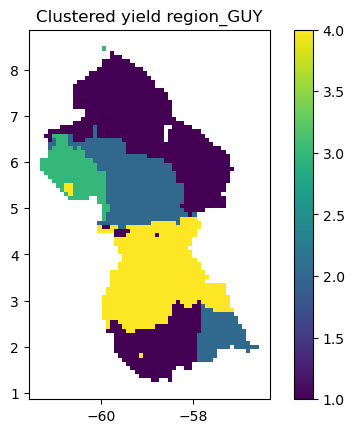

In [53]:

# Choose optimum number of clusters
default_cluster = 3  # Default number of clusters

for i in regions_normalized_list:
    user_input = input("Enter the optimum number of clusters in {} (or press Enter for default): ".format(i))

    # Use the user input or the default value
    number_cluster = int(user_input.strip()) if user_input else default_cluster

    for j in regions_list:
        if j in i:
            # Perform agglomerative hierarchical clustering
            agglomerative_clustering (regions_gdf[j], regions_normalized_gdf[i] , number_cluster, j)


# Part 6: Statistics Calculation

This part calculates summary statistics for the generated clusters. There outputs include:

* Tabular summaries (.csv format) grouped by cluster

## 6.1. Calculating Cluster Summaries

In [54]:
#Collect Names of Attributes Assigned to the Clusters
origin_list_of_cols = list(final_clustered_GAEZ_gdf.columns)
final_list_of_cols = list(land_cells.columns)

In [55]:
# Land cover area estimator
def calc_LC_sqkm(df, col_list):
    """ 
    This function takes the df where the LC type for different classes is provided per location (row).
    It adds all pixels per location; then is calculates the ratio of LC class in each location (% of total).
    Finally is estimates the area per LC type in each location by multiplying with the total area each row represents.
    
    INPUT: 
    df -> Pandas dataframe with LC type classification 
    col_list -> list of columns to include in the summary (e.g. LC1-LC11)
    
    OUTPUT: Updated dataframe with estimated area (sqkm) of LC types per row
    """
    df["LC_sum"] = df[col_list].sum(axis=1)
    for col in col_list:
        df[col] = df[col]/df["LC_sum"]*df["sqkm"]
    
    return df


In [56]:
# Identify land cover related columns
landCover_cols = []
for col in final_list_of_cols:
    if "LCType" in col:
        landCover_cols.append(col)
if not landCover_cols:
    print ("There is not any Land Cover associated column in the dataframe; please revise")
else:
    pass

In [57]:
data_gdf_LCsqkm_list = []
data_gdf_LCsqkm = {}

for i in regions_list:
    data_gdf_LCsqkm_name = 'data_gdf_LCsqkm_'+ i
    data_gdf_LCsqkm_list.append(data_gdf_LCsqkm_name)
    data_gdf_LCsqkm [data_gdf_LCsqkm_name]= calc_LC_sqkm (regions_gdf[i], landCover_cols)

## 6.2 Unit Conversion  

In [58]:
#new
# Calculate summary statistics for other than land cover attribute columns
data_gdf_stat = data_gdf_LCsqkm

# Define the conversion factor for CLEWs modelling
#Potential yield unit conversion from kg DW/ha to million tonnes per 1000 sqkm
factor1 = 0.0001 

#Other parameter unit conversion from millimeter to BCM per 1000 sqkm
factor2 = 0.001

for i in data_gdf_LCsqkm_list:
    for col in data_gdf_stat[i].columns:

        if "yld" in col:
            data_gdf_stat[i].loc[:, col] *= factor1
        elif "evt" in col: 
            data_gdf_stat[i].loc[:, col] *= factor2
        elif "prc" in col: 
            data_gdf_stat[i].loc[:, col] *= factor2
        elif "cwd" in col: 
            data_gdf_stat[i].loc[:, col] *= factor2     
    final_list_of_cols = list(data_gdf_stat[i].columns)


In [59]:

sum_cols = [x for x in final_list_of_cols if x not in origin_list_of_cols]
sum_cols = [x for x in sum_cols if x not in landCover_cols]
sum_cols.remove("id")
sum_cols.remove("LC_sum")

## 6.3. Land Cover and Area Statistics

In [60]:
group_lc = {}

for key, gdf in data_gdf_stat.items():
    # Group by 'clusters_yield'
    clusters = gdf.groupby(['clusters_yield'])
    
    
    clusters_lc = clusters[landCover_cols].sum().merge(clusters["sqkm"].sum().reset_index(name="sqkm"), on="clusters_yield").round(decimals=1)
    clusters_lc = clusters_lc.sort_values(ascending=True, by='clusters_yield').reset_index(drop=True)
    name = key[-3:]
    
    #Export land cover stats to csv
    clusters_lc.to_csv(os.path.join(summary_stats_path,"{}_LandCover_byCluster_summary.csv".format(name)),index_label='cluster')

    # Display summary statistics
    display(Markdown('#### Cluster summary statistics for area and land cover in {}'.format(name)))
    display(Markdown(' **Total area:** {:0.1f} sq.km'.format(clusters_lc.sqkm.sum())))
    display(clusters_lc)

    # Store the result in the group_dic dictionary
    group_lc[key] = clusters_lc



#### Cluster summary statistics for area and land cover in GUY

 **Total area:** 209877.6 sq.km

,clusters_yield,LCType2,LCType3,LCType6,LCType7,LCType10,sqkm
0,1,79218.0,1310.9,6852.8,725.2,4416.1,92522.9
1,2,46597.1,49.7,149.0,322.9,0.0,47118.7
2,3,15087.5,0.0,755.1,49.7,0.0,15990.9
3,4,43076.1,6258.7,2364.5,1932.6,613.1,54245.1


### 6.4. Calculating the Average of Additional Crops

In [61]:
#Add new column contain average value of five to ten in the top 10 crops 
def additional_stat_group(parameter):
    selected_group = [col for col in additional_stat_table_group.columns if parameter in col]

    selected_group = additional_stat_table_group.loc[:, selected_group]
    
    Irrigation_Low_group = selected_group.loc[:, [a for a in selected_group.columns if 'Irrigation Low' in a]]
    Low_group = round(Irrigation_Low_group.mean(axis=1),4)
    clusters_stat['OTH'+' '+ parameter +' '+'Irrigation Low_mean'] = Low_group
    
    Irrigation_High_group = selected_group.loc[:, [a for a in selected_group.columns if 'Irrigation High' in a]]
    High_group = round(Irrigation_High_group.mean(axis=1),4)            
    clusters_stat['OTH'+' '+ parameter +' '+ 'Irrigation High_mean'] = High_group    


    Rain_fed_Low_group = selected_group.loc[:, [a for a in selected_group.columns if 'Rain-fed Low' in a]]   
    Rain_Low = round(Rain_fed_Low_group.mean(axis=1),4)            
    clusters_stat['OTH'+' '+ parameter +' '+ 'Rain-fed Low_mean'] = Rain_Low 
                
    Rain_fed_High_group = selected_group.loc[:, [a for a in selected_group.columns if 'Rain-fed High' in a]]         
    Rain_High = round(Rain_fed_High_group.mean(axis=1),4)               
    clusters_stat['OTH'+' '+ parameter +' '+ 'Rain-fed High_mean'] =Rain_High  


### 6.5. Other Variable Statistics

In [62]:
group_stat = {}
for key, gdf in data_gdf_stat.items():
    # Group by 'clusters_yield'
    clusters = gdf.groupby(['clusters_yield'])
    
    clusters_stat = clusters[sum_cols].mean().round(decimals = 4)

    
    additional_crop_stat_group = [col for col in clusters_stat.columns if any(a in col for a in other_crop_name)]
    additional_stat_table_group = clusters_stat.loc[:, additional_crop_stat_group].copy()
    clusters_stat = clusters_stat.drop(additional_stat_table_group, axis=1)
    
    additional_stat_group('yld')
    additional_stat_group('cwd')
    additional_stat_group('evt')
    
    name = key[-3:]
    
    display(Markdown('#### Cluster summary statistics for other variables in {}'.format(name)))
    display(clusters_stat)

    
    group_stat[key] = clusters_stat
    

#### Cluster summary statistics for other variables in GUY

,MZE cwd Rain-fed Low_mean,CON evt Irrigation High_mean,CON evt Rain-fed High_mean,CON evt Irrigation Low_mean,SGC cwd Rain-fed High_mean,MZE evt Irrigation Low_mean,SGC evt Irrigation High_mean,CON yld Rain-fed High_mean,MZE cwd Irrigation High_mean,SGC yld Irrigation Low_mean,...,OTH yld Rain-fed Low_mean,OTH yld Rain-fed High_mean,OTH cwd Irrigation Low_mean,OTH cwd Irrigation High_mean,OTH cwd Rain-fed Low_mean,OTH cwd Rain-fed High_mean,OTH evt Irrigation Low_mean,OTH evt Irrigation High_mean,OTH evt Rain-fed Low_mean,OTH evt Rain-fed High_mean
clusters_yield,,,,,,,,,,,,,,,,,,,,,
1,0.001,0.8357,0.8829,0.7320,0.0810,0.4168,1.1994,0.4763,0.0044,0.2717,...,0.1690,0.6270,0.0011,0.0252,0.0246,0.0238,0.8101,0.9095,0.7938,0.9379
2,0.001,0.8554,0.8719,0.6126,0.0242,0.4263,1.2343,0.4307,0.0117,0.2748,...,0.1349,0.5930,0.0010,0.0020,0.0028,0.0144,0.8230,0.9468,0.8347,0.9294
3,0.001,0.4858,0.4969,0.0550,0.0116,0.4144,1.1889,0.2628,0.0010,0.3756,...,0.1481,0.6488,0.0010,0.0010,0.0010,0.0017,0.7782,0.9010,0.7773,0.8834
4,0.001,0.7821,0.8771,0.0355,0.2257,0.4372,1.1681,0.4472,0.0129,0.2804,...,0.2085,0.6218,0.0080,0.1010,0.1342,0.0769,0.8562,0.8680,0.7545,0.9086


## 6.6. Generate clewsy-compatible Statistics

In [63]:
for key, gdf in group_stat.items():    
    clusters_other = gdf
    
    name = key[-3:]

    # generating the crop potential yeild csv files
    yld_columns = [col for col in clusters_other.columns if 'yld' in col]
    yld_df = clusters_other[yld_columns]

    # Name correction according clewsy format
    yld_rename = {col: col.replace(' yld', '').replace('_mean', '') for col in yld_df.columns}
    yld_df = yld_df.rename(columns=yld_rename)
    empty_yld = pd.DataFrame(columns=['', '', '', '','', '', '', '', ''],index= yld_df.index)
    combined_yld = pd.concat([empty_yld, yld_df], axis=1)

    #Store as CSV file
    combined_yld.to_csv(os.path.join(summary_stats_path,"clustering_results_{}.csv".format(name)), index= True, index_label='cluster')


    # generating crop evapotranspiration csv files
    evt_columns = [col for col in clusters_other.columns if 'evt' in col]
    evt_df = clusters_other[evt_columns]

    # Name correction
    evt_rename = {col: col.replace(' evt', '').replace('_mean', '') for col in evt_df.columns}
    evt_df = evt_df.rename(columns=evt_rename)
    empty_evt = pd.DataFrame(columns=['', '', '', '','', '', '', '', ''],index= evt_df.index)
    combined_evt = pd.concat([empty_evt, evt_df], axis=1)

    combined_evt.to_csv(os.path.join(summary_stats_path,"clustering_results_evt_{}.csv".format(name)), index= True, index_label='cluster')



    #generating crop water deficit csv files 
    cwd_columns = [col for col in clusters_other.columns if 'cwd' in col]
    cwd_df = clusters_other[cwd_columns]

    # Name correction
    cwd_rename = {col: col.replace(' cwd', '').replace('_mean', '') for col in cwd_df.columns}
    cwd_df = cwd_df.rename(columns=cwd_rename)
    empty_cwd = pd.DataFrame(columns=['', '', '', '','', '', '', '', ''],index= cwd_df .index)
    combined_cwd = pd.concat([empty_cwd, cwd_df], axis=1)

    combined_cwd.to_csv(os.path.join(summary_stats_path,"clustering_results_cwd_{}.csv".format(name)), index= True, index_label='cluster')


    # generating precipitation csv files
    prc_columns = [col for col in clusters_other.columns if 'prc' in col]
    prc_df = clusters_other[prc_columns]

    prc_rename = {col: col.replace(' prc', '').replace('_mean', '') for col in prc_df.columns}
    prc_df = prc_df.rename(columns=prc_rename)

    prc_df.to_csv(os.path.join(summary_stats_path,"clustering_results_prc_{}.csv".format(name)), index= True, index_label='cluster')


    #Export summary stats to csv
    clusters_other.to_csv(os.path.join(summary_stats_path,"{}_Parameter_byCluster_summary.csv".format(name)))


In [64]:
print ("Part 6 - and with that the analysis - completed!")
print ("Total elapsed time: {}".format(time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))))

Part 6 - and with that the analysis - completed!
Total elapsed time: 00:13:10
